In [1]:
import tensorflow as tf

import os
import pathlib
import time
import datetime
import numpy as np
import io_utils

from matplotlib import pyplot as plt
from IPython import display

print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.9.0


In [2]:
if tf.test.gpu_device_name(): 
    print("Default GPU: {}".format(tf.test.gpu_device_name()))
else:
    print("Not using a GPU - it will take long!!")

Default GPU: /device:GPU:0


In [3]:
from configuration import *
# DATASET_SIZE *= NUMBER_OF_DOMAINS
# TRAIN_SIZE *= NUMBER_OF_DOMAINS
# TEST_SIZE *= NUMBER_OF_DOMAINS
# TRAIN_SIZES = [NUMBER_OF_DOMAINS * s for s in TRAIN_SIZES]
# TEST_SIZES = [NUMBER_OF_DOMAINS * s for s in TEST_SIZES]

print("DATASET_SIZE", DATASET_SIZE)
print("TRAIN_SIZE", TRAIN_SIZE)
print("TEST_SIZE", TEST_SIZE)

np.random.seed(SEED)
tf.random.set_seed(SEED)

DATASET_SIZE 294
TRAIN_SIZE 250
TEST_SIZE 44


In [4]:
from dataset_utils import normalize_two_with_labels as normalize, create_augmentation_with_prob_with_labels as create_augmentation_with_prob

model = "unpaired-stargan"
# model = "paired-stargan"

if model == "unpaired-stargan":
    from dataset_utils import create_unpaired_image_loader as create_image_loader

    train_dataset = tf.data.Dataset.range(TRAIN_SIZE*NUMBER_OF_DOMAINS).shuffle(TRAIN_SIZE*NUMBER_OF_DOMAINS)
    train_dataset = train_dataset.map(create_image_loader(TRAIN_SIZES, "train", True), num_parallel_calls=tf.data.AUTOTUNE)
    train_dataset = train_dataset.batch(BATCH_SIZE)

    test_dataset = tf.data.Dataset.range(TEST_SIZE*NUMBER_OF_DOMAINS).shuffle(TEST_SIZE*NUMBER_OF_DOMAINS)
    test_dataset = test_dataset.map(create_image_loader(TEST_SIZES, "test", True))
    test_dataset = test_dataset.batch(BATCH_SIZE)

    
    
elif model == "paired-stargan":
    from dataset_utils import create_paired_star_image_loader as create_image_loader

    train_dataset = tf.data.Dataset.range(TRAIN_SIZE).shuffle(TRAIN_SIZE)
    train_dataset = train_dataset.map(create_image_loader(TRAIN_SIZES, "train", False, 0.05), num_parallel_calls=tf.data.AUTOTUNE)
    train_dataset = train_dataset.map(create_augmentation_with_prob(0.8), num_parallel_calls=tf.data.AUTOTUNE)
    train_dataset = train_dataset.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
    train_dataset = train_dataset.batch(BATCH_SIZE)

    test_dataset = tf.data.Dataset.range(TEST_SIZE).shuffle(TEST_SIZE)
    test_dataset = test_dataset.map(create_image_loader(TEST_SIZES, "test", True))
    test_dataset = test_dataset.batch(BATCH_SIZE)

D:\Projetos 2\pixel-sides\venv\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


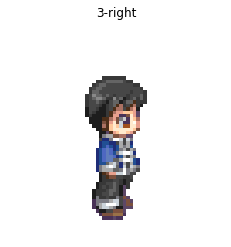

In [5]:
def show_example(dataset):
    example_image, example_domain = next(iter(dataset))#[0]
    example_image = (example_image + 1.0) / 2.0
    domain_index = tf.argmax(tf.squeeze(example_domain)).numpy()
    domain_name = DIRECTION_FOLDERS[domain_index]
    
    plt.title(domain_name, fontdict={"fontsize": 12})
    plt.imshow(tf.squeeze(example_image), vmin=0.0, vmax=1.0)
    plt.axis("off")

show_example(train_dataset.unbatch().take(1).batch(1))
# train_dataset.repeat().take(5).enumerate()


In [6]:
from stargan_model import StarGANModel, PairedStarGANModel

if model == "unpaired-stargan":
    model = StarGANModel(train_dataset, test_dataset, "unpaired", "stargan-playground",
                         # generator_type="unet",
                         discriminator_steps=1,
                         lambda_domain=1.)
elif model == "paired-stargan":
    model = PairedStarGANModel(train_dataset, test_dataset, "paired-lr0002-unet", "stargan-playground",
                               generator_type="unet",
                               discriminator_steps=1,
                               lambda_l1=100.,
                               lambda_domain=1.)

In [7]:
print("Generator:")
model.generator.summary()
print("Discriminator:")
model.discriminator.summary()

Generator:
Model: "StarGANGenerator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 8)]  0           []                               
                                                                                                  
 conv2d_94 (Conv2D)             (None, 64, 64, 64)   25088       ['input_2[0][0]']                
                                                                                                  
 instance_normalization (Instan  (None, 64, 64, 64)  128         ['conv2d_94[0][0]']              
 ceNormalization)                                                                                 
                                                                                                  
 re_lu (ReLU)                   (None, 64, 64, 64)   0           ['insta

Time since start: 33m:37s
Estimated time to finish: 00m:03s
Last 15 steps took: 46.65s



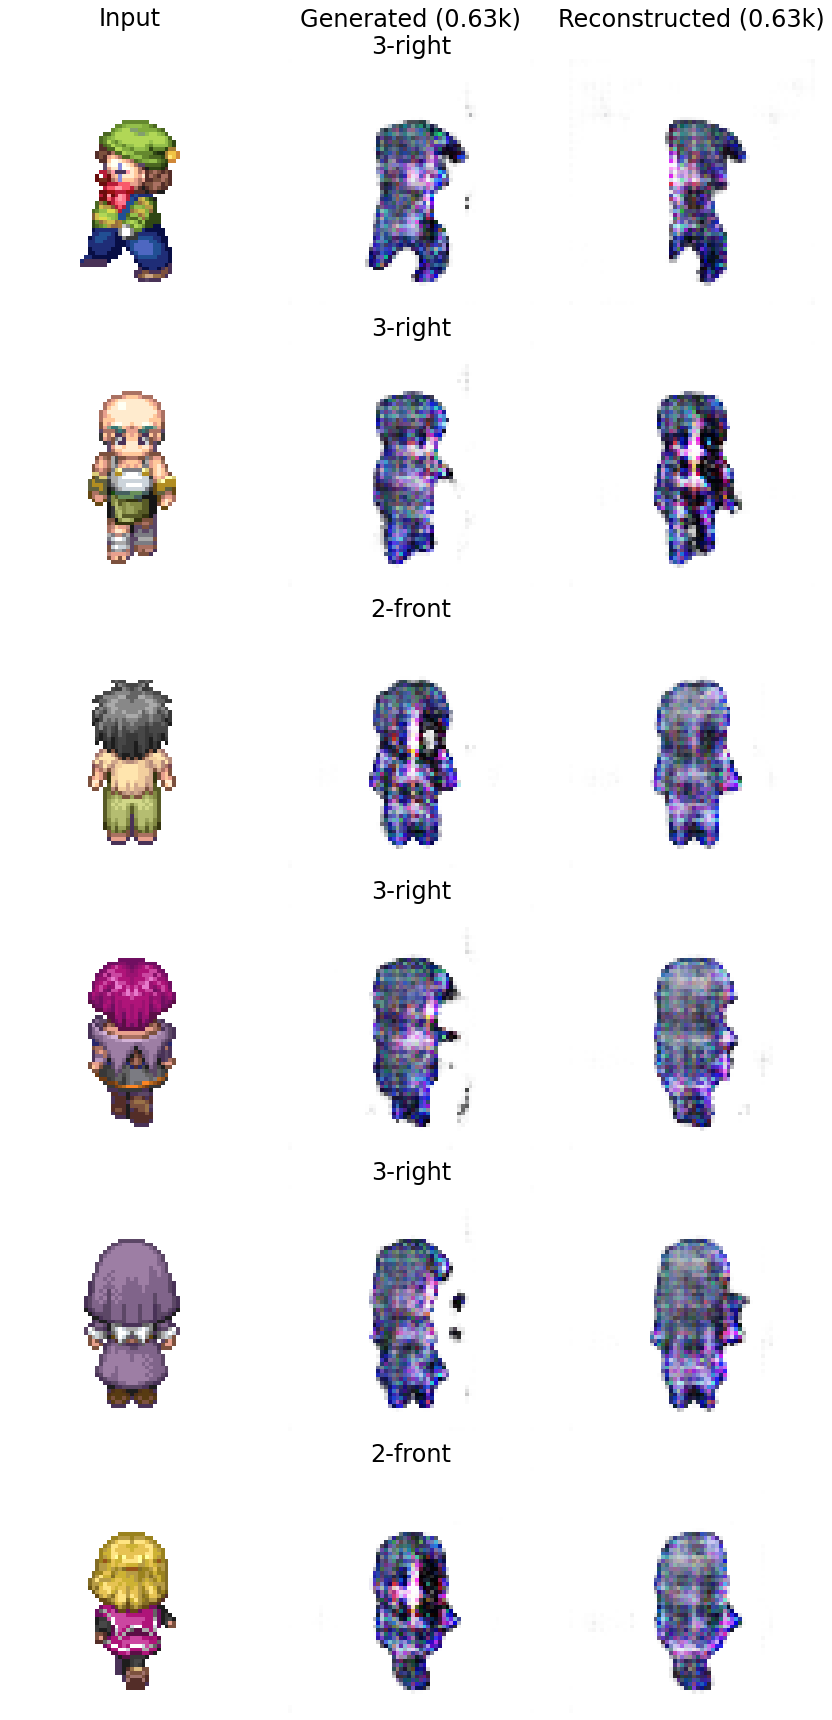

Showing discriminator patches...


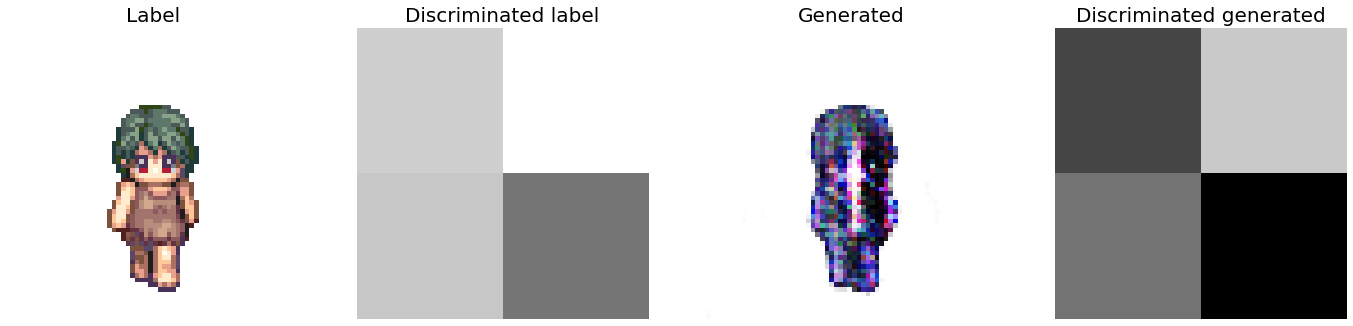

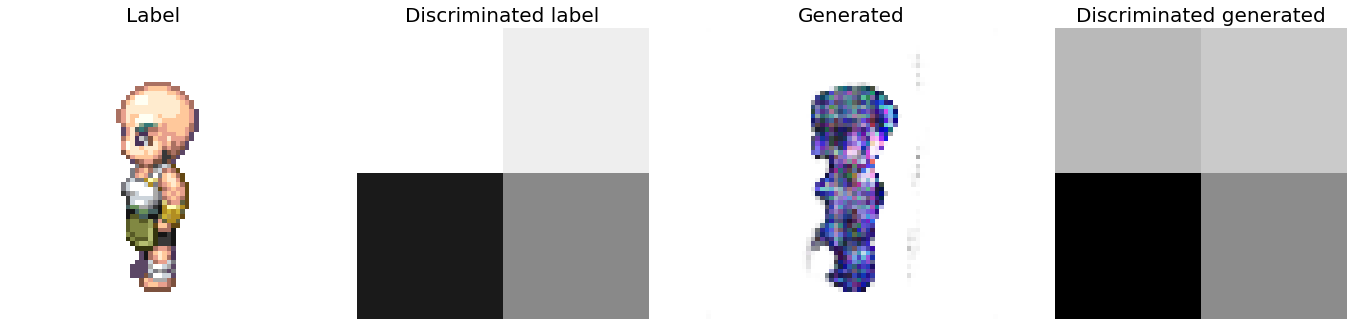

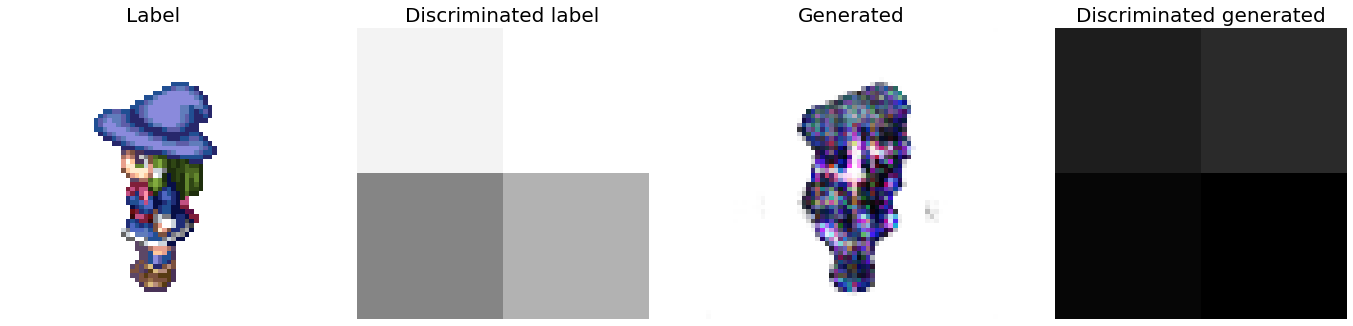

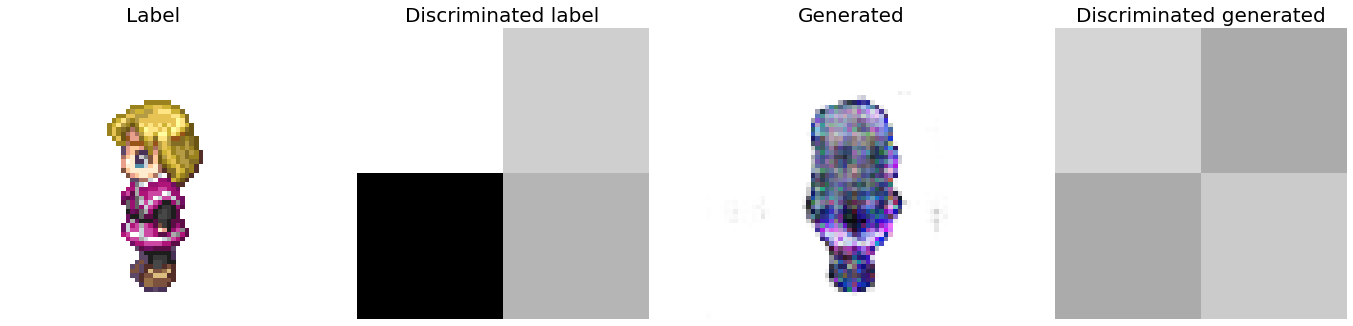

Comparing L1 between generated images from train and test... L1: 0.08428 / 0.08874 (train/test)
2/2 [==============================] - 0s 228ms/step
 FID: 27.883 / 33.061 (train/test)
Step: 0.63k


In [8]:
EPOCHS = 160//16
STEPS = ceil(TRAIN_SIZE / BATCH_SIZE) * EPOCHS
UPDATE_STEPS = STEPS // (40)

print("Starting training...")
model.fit(STEPS, UPDATE_STEPS, callbacks=["fid", "show_patches", "l1"])

In [9]:
SHOULD_GENERATE_ALL_IMAGES_FROM_TEST=True
SHOULD_SAVE_RESULTS=False

In [10]:
if SHOULD_SAVE_RESULTS:
    model.save_generator()
    model.save_discriminator()

Showing some images from TRAIN


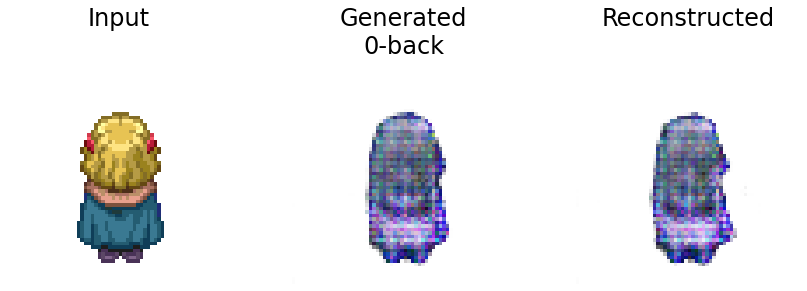

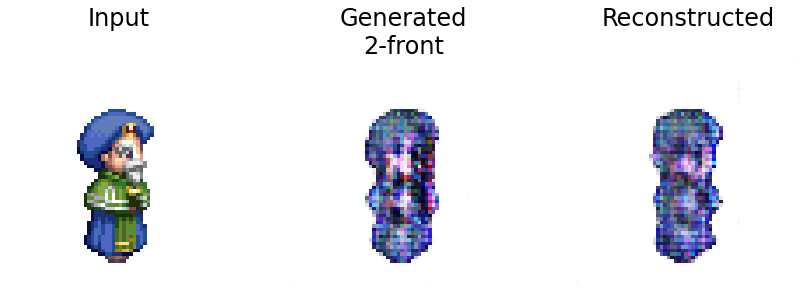

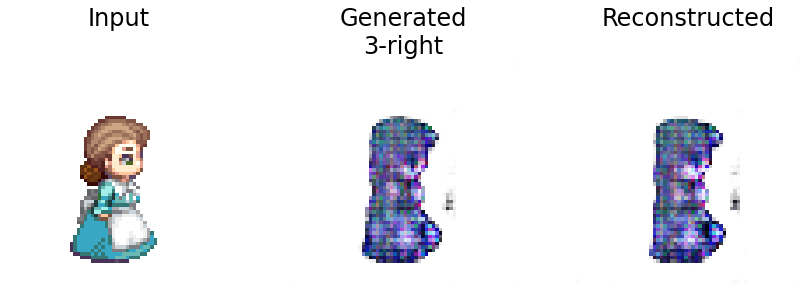

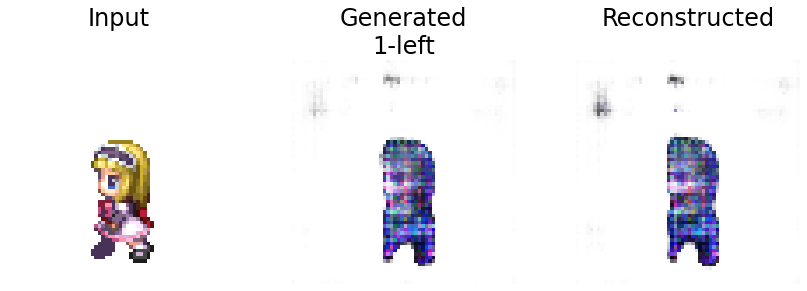

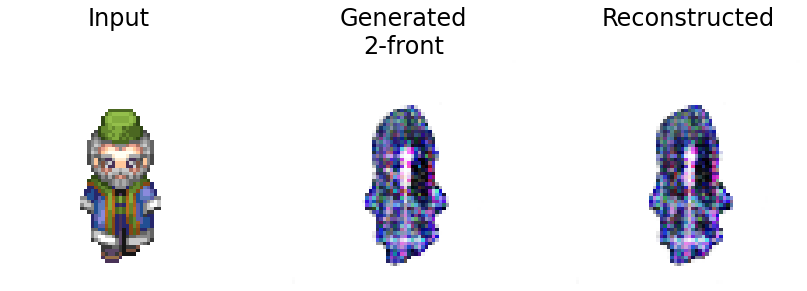

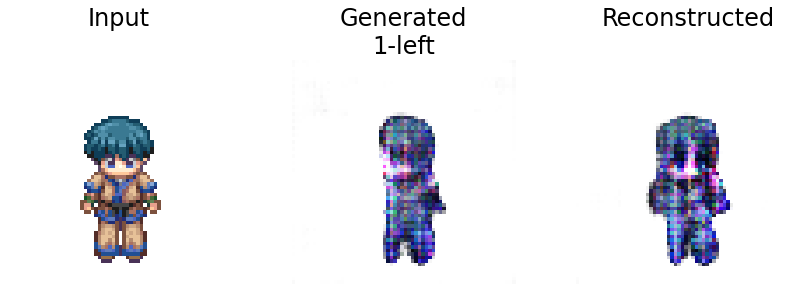

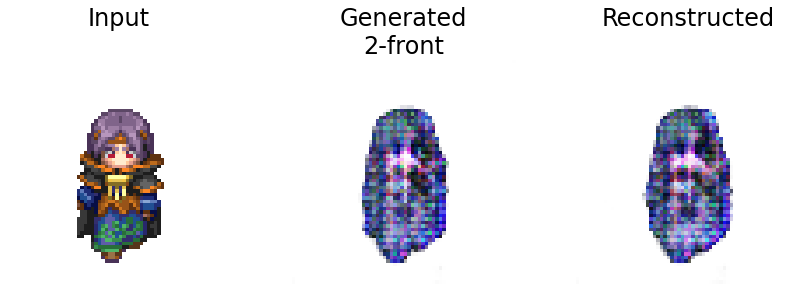

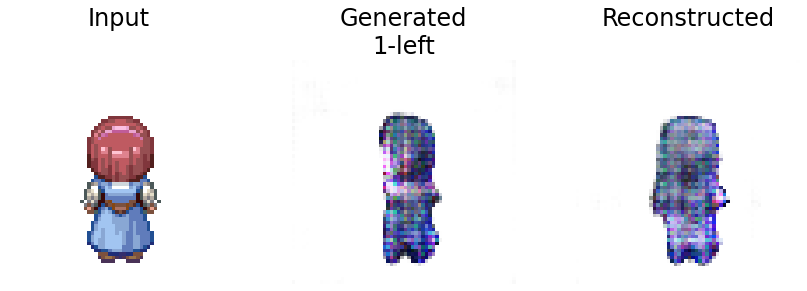

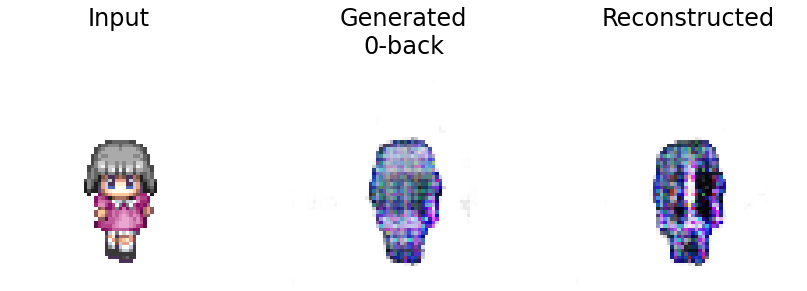

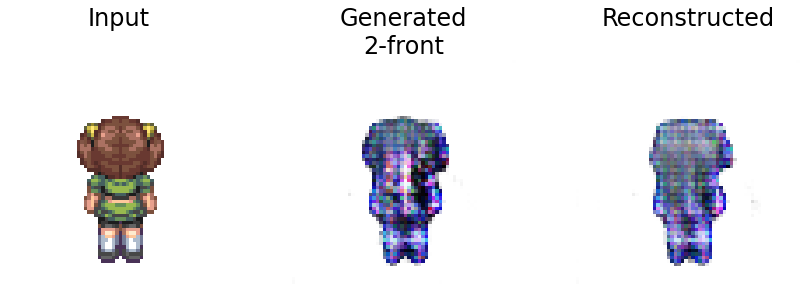

Generated 10 images (using "train" dataset)
Showing ALL images from TEST


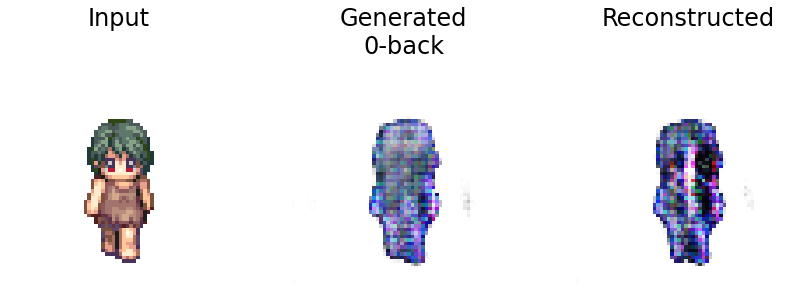

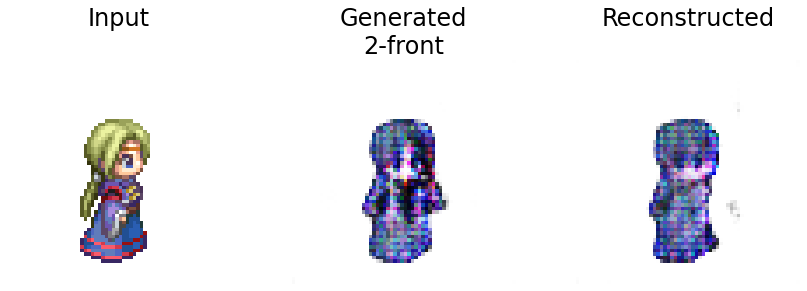

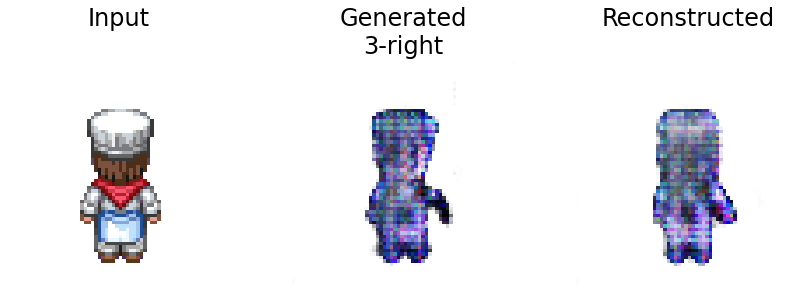

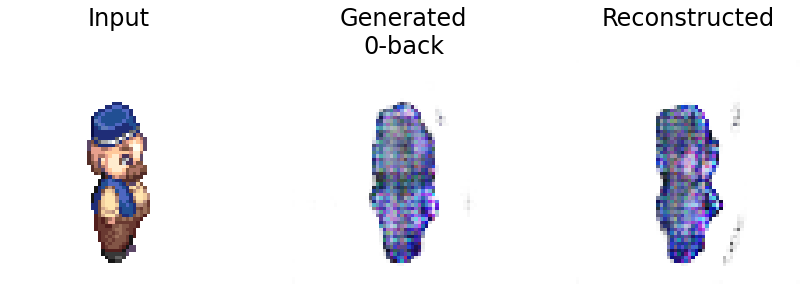

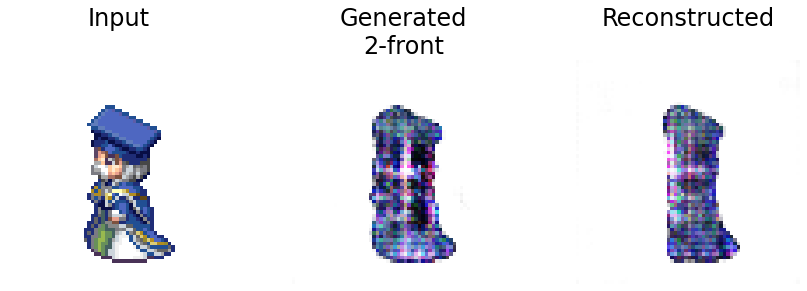

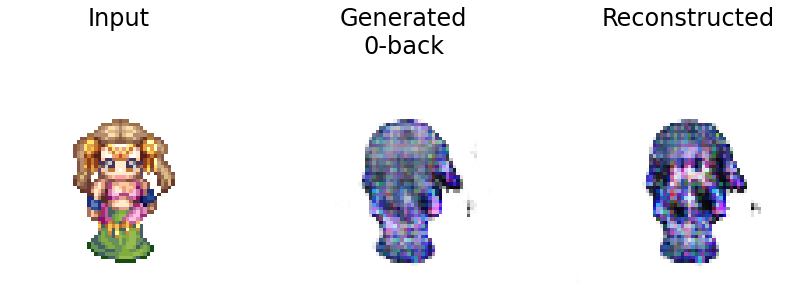

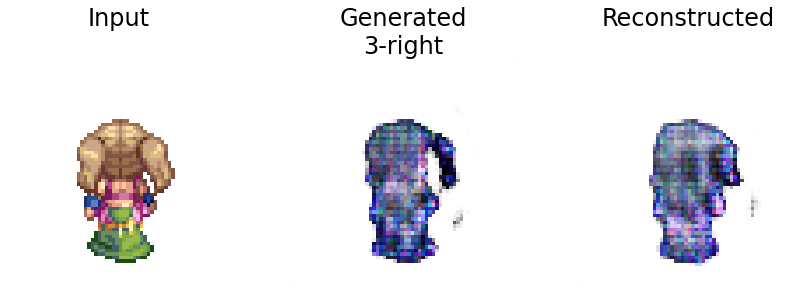

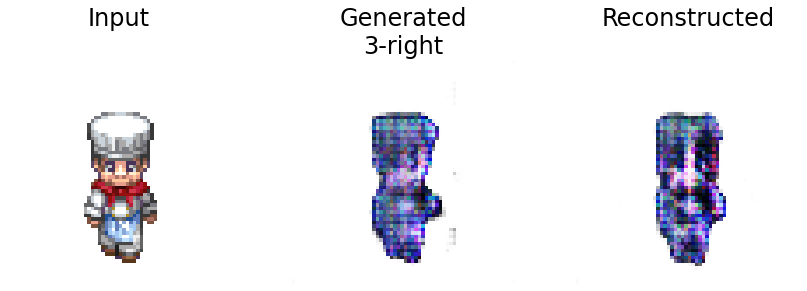

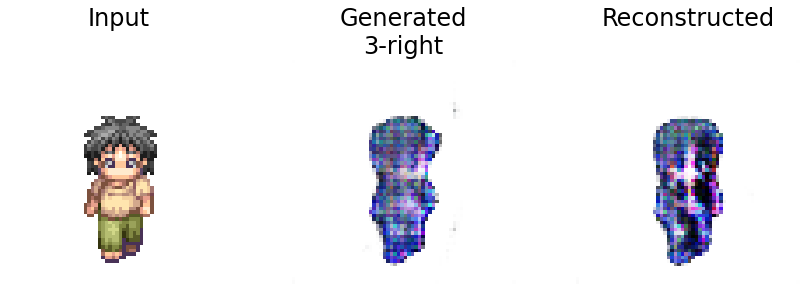

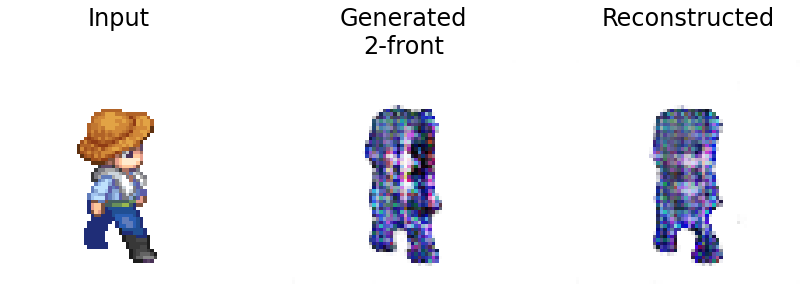

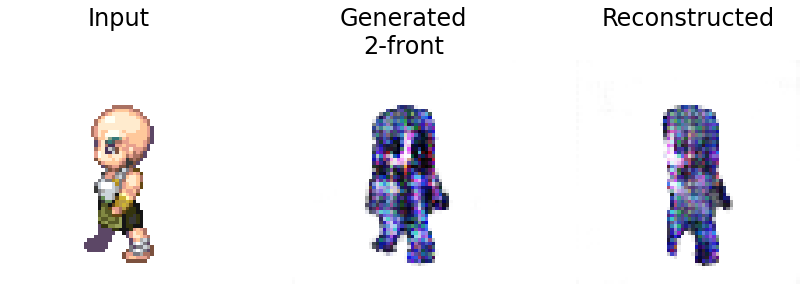

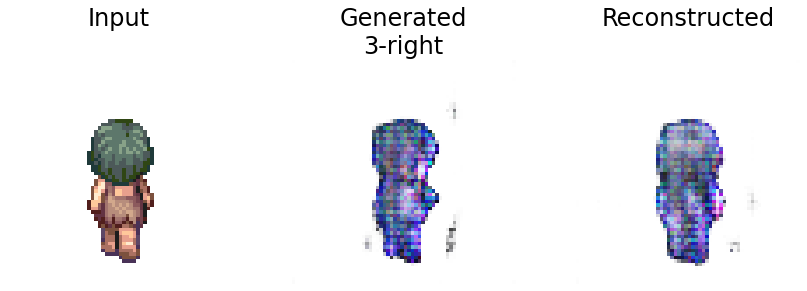

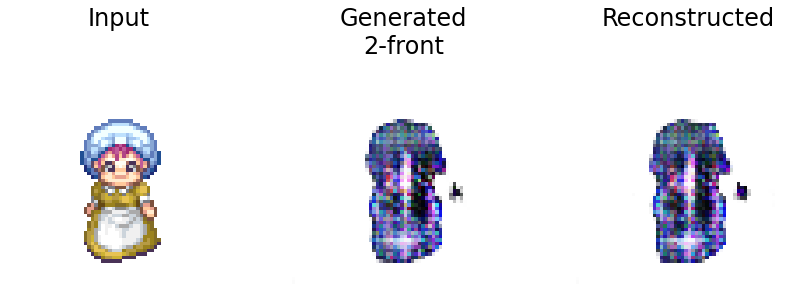

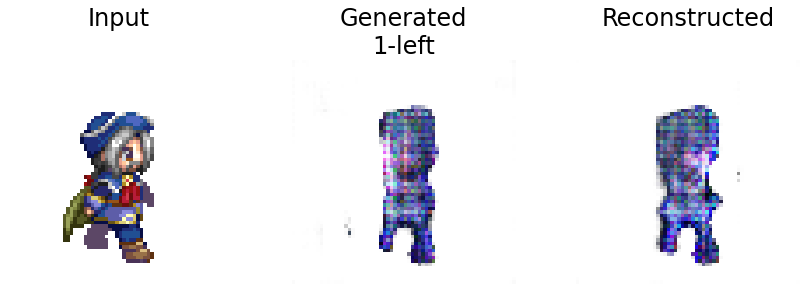

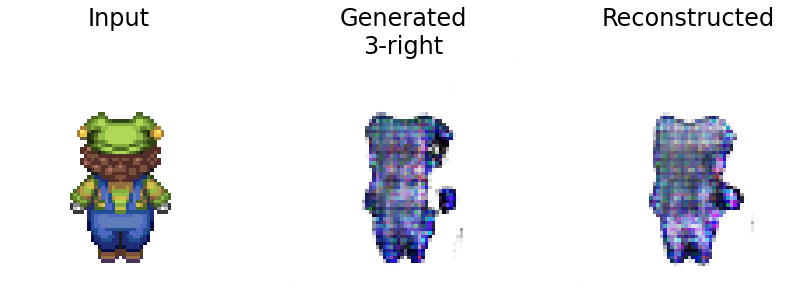

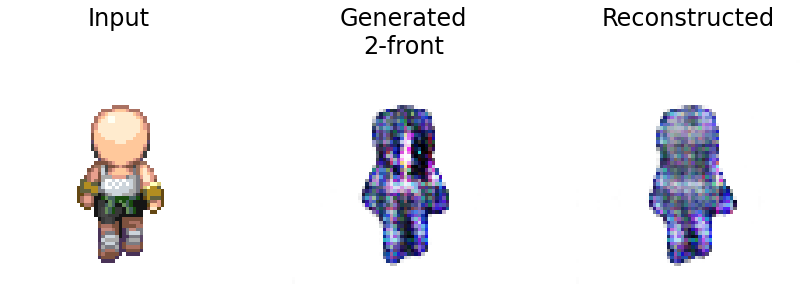

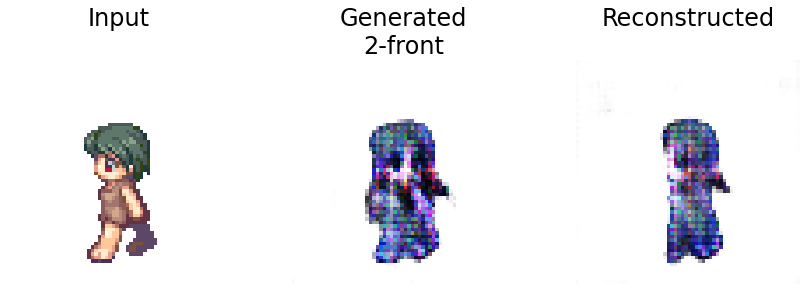

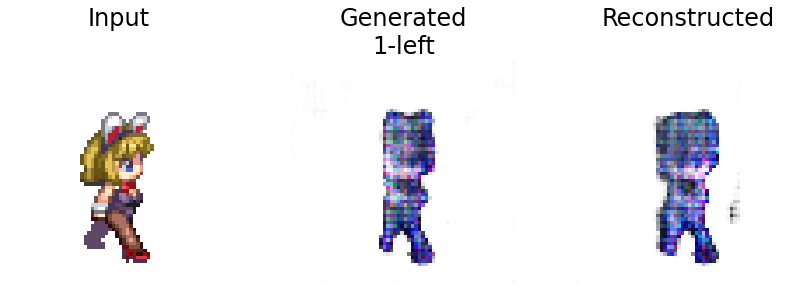

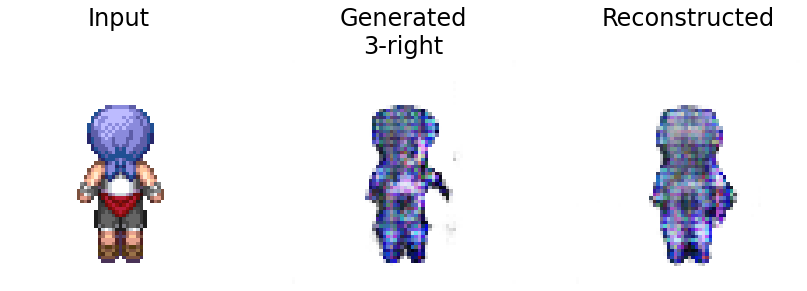

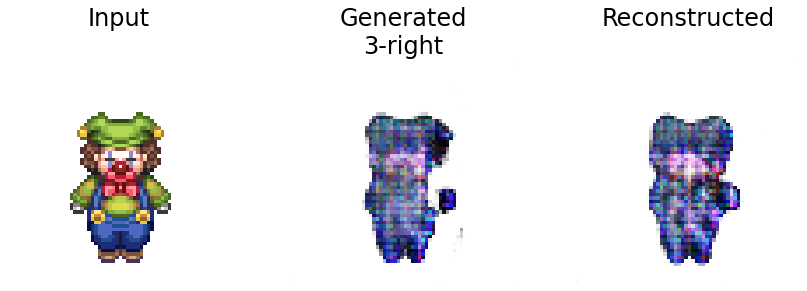

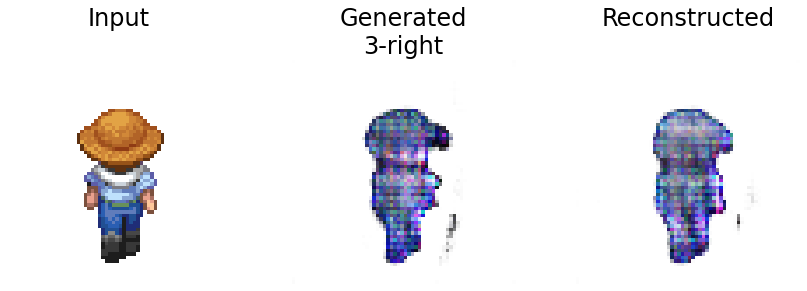

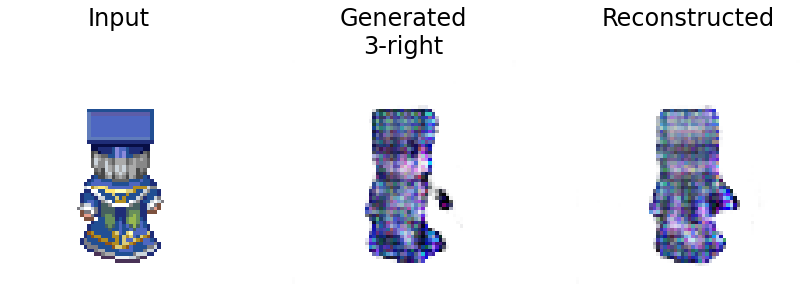

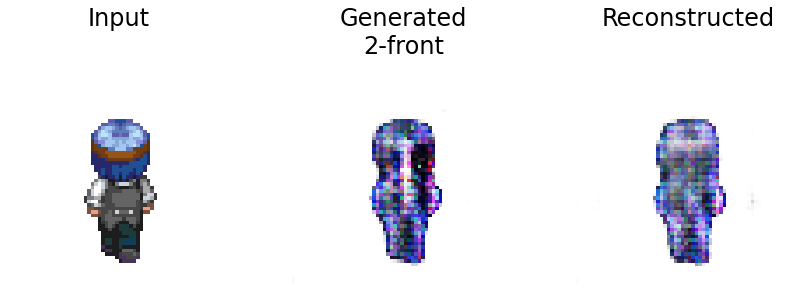

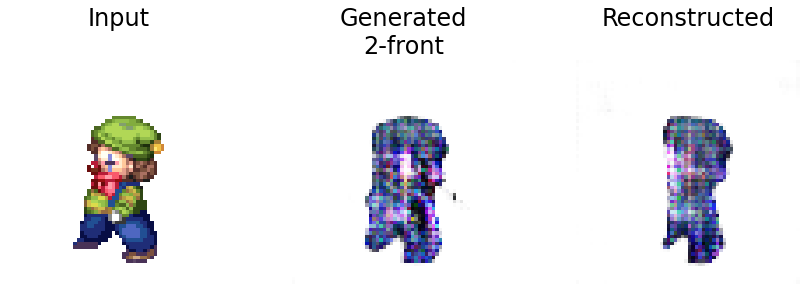

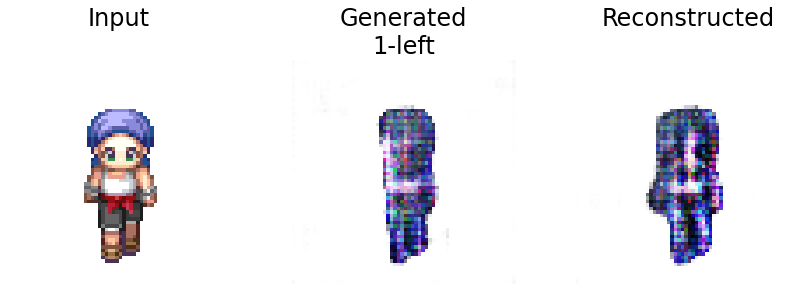

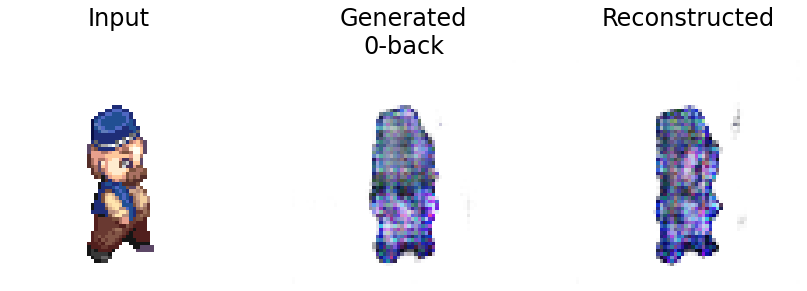

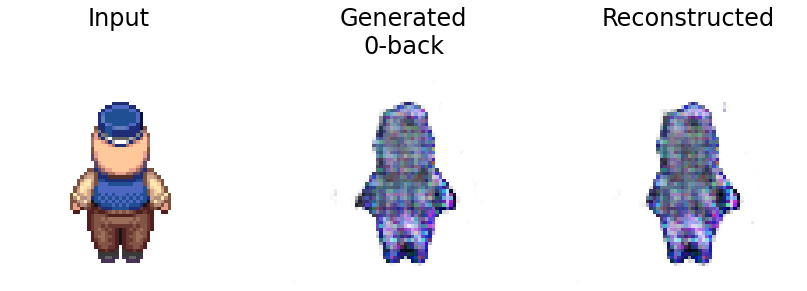

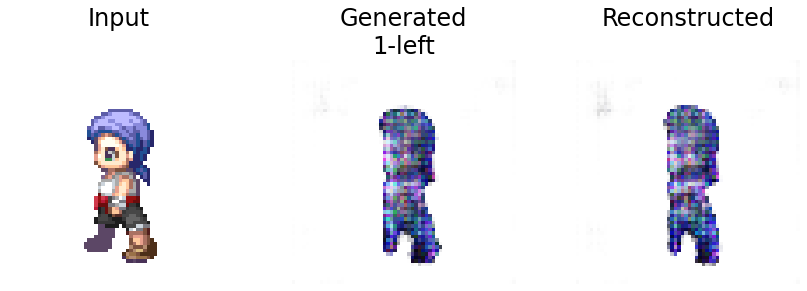

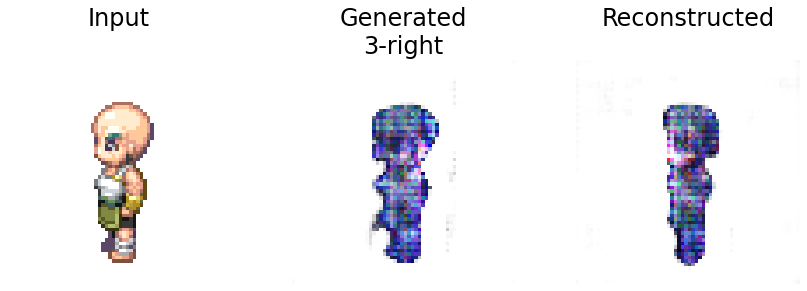

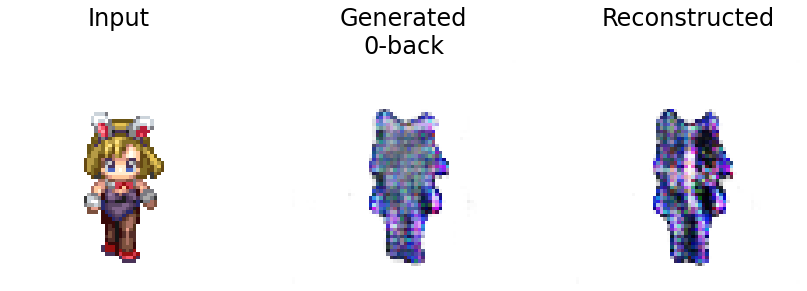

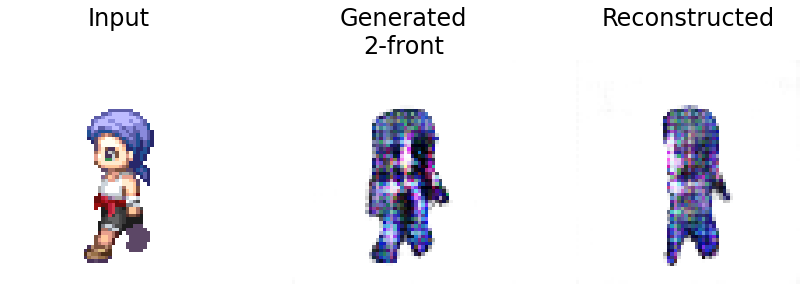

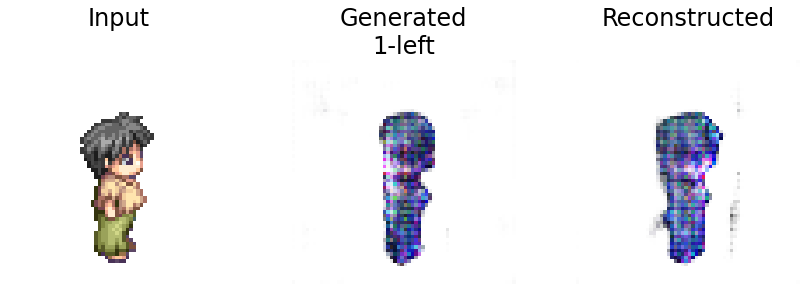

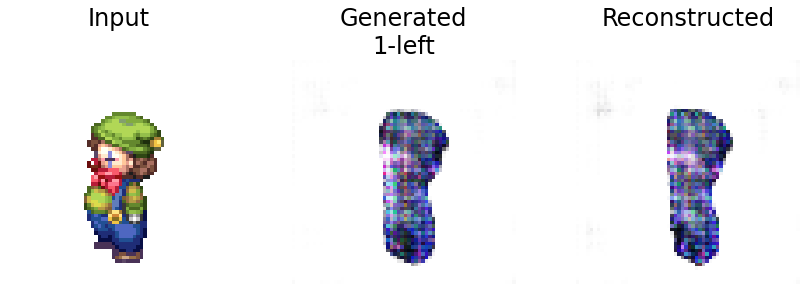

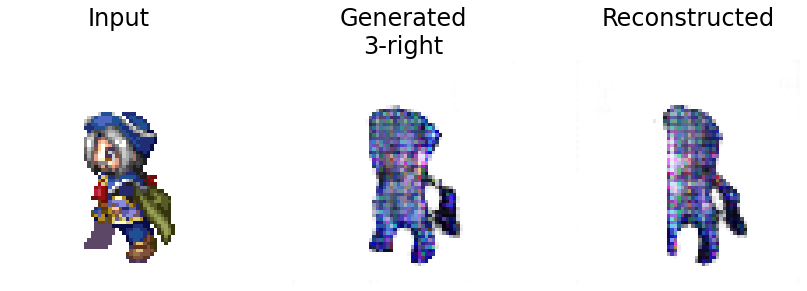

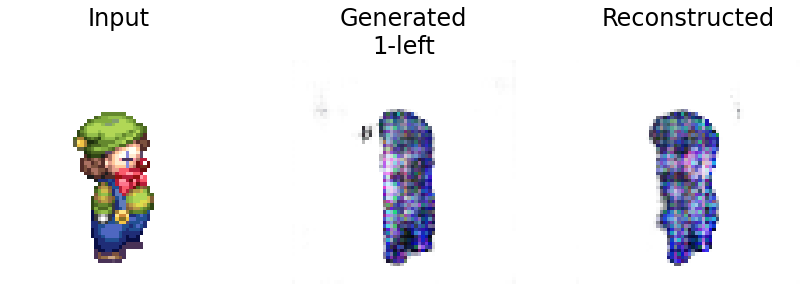

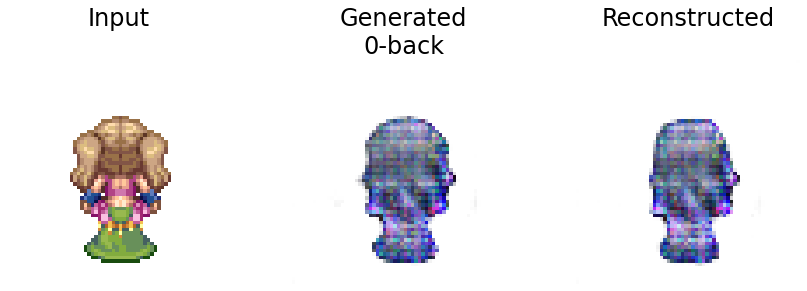

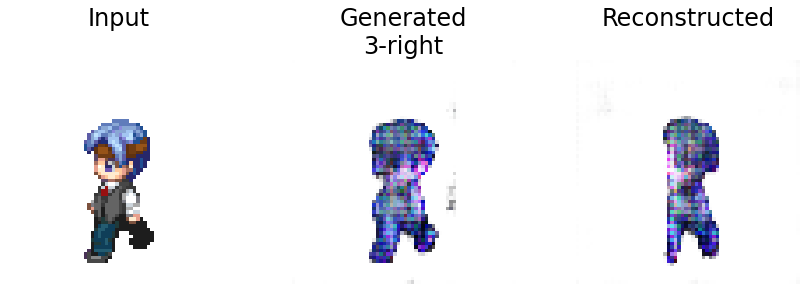

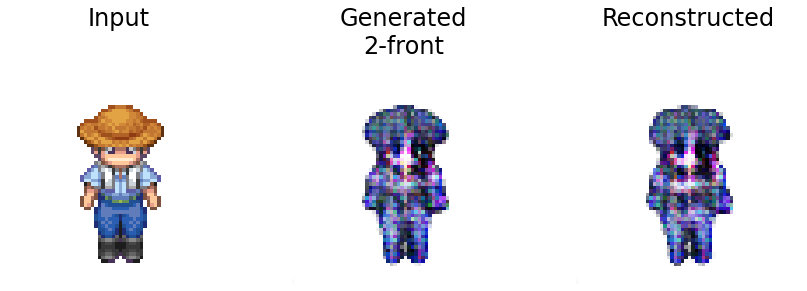

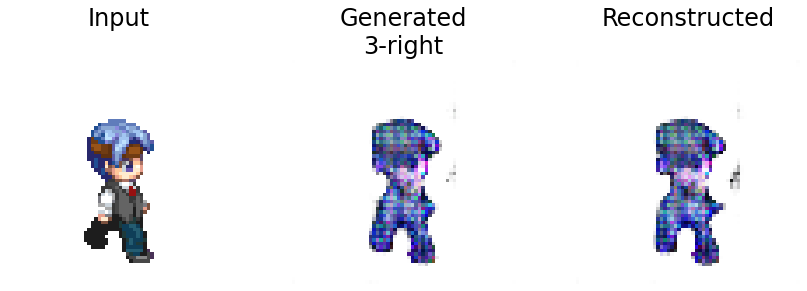

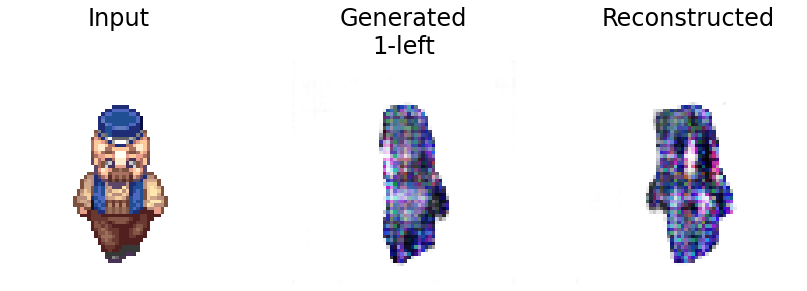

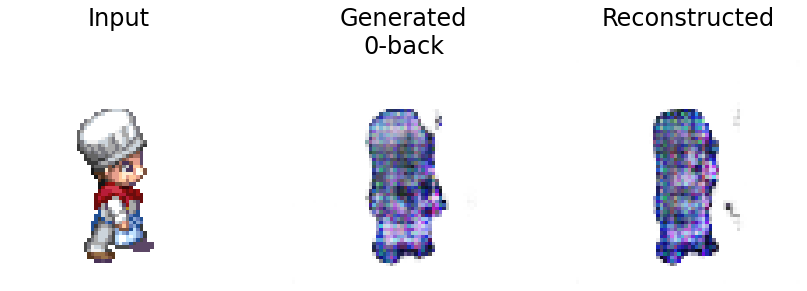

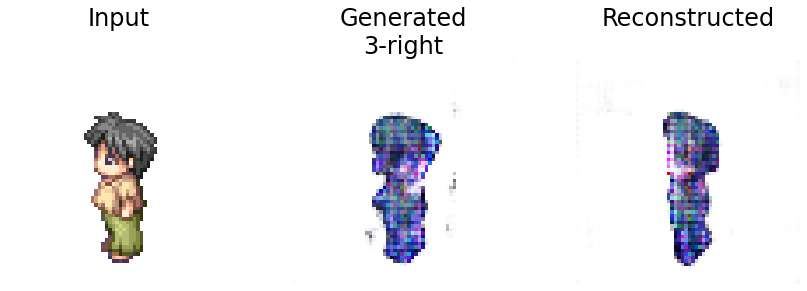

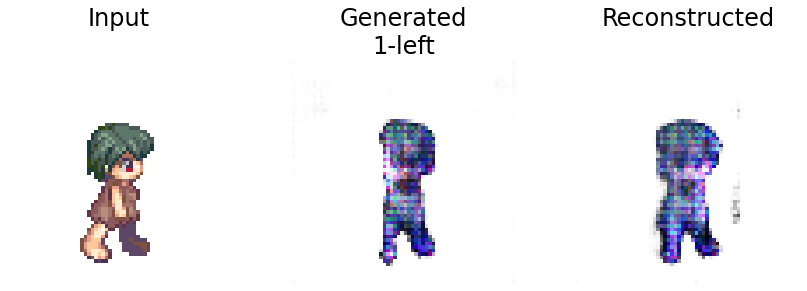

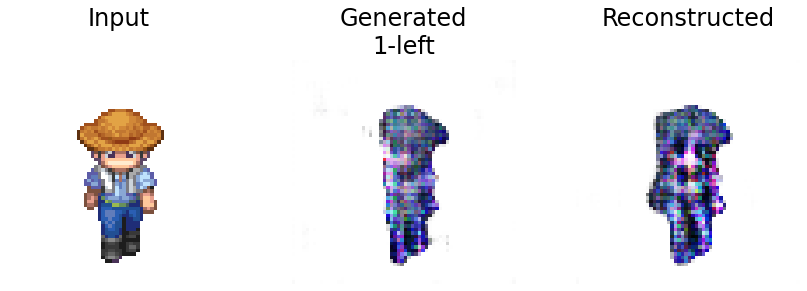

Generated 44 images (using "test" dataset)


In [11]:
if SHOULD_GENERATE_ALL_IMAGES_FROM_TEST:
    print("Showing some images from TRAIN")
    model.generate_images_from_dataset(dataset_name="train", num_images=10)
    print("Showing ALL images from TEST")
    model.generate_images_from_dataset(dataset_name="test", num_images=TEST_SIZE)